## Workflow to analyze Photometry data

```bash
jupyter nbconvert "D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20221004_104500_workflow_pyPhot_CuedUncued_last5.ipynb" --to="python" --output-dir="D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical" --output="nb20221004_104500_workflow_pyPhot_CuedUncued_last5"
```

### Imports

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables

In [77]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.path.split(os.getcwd())[0])

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params\\tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

# photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\kms_pyphotometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'


### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [78]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

task             triggers  \
0                           lick_go_nogo             go; nogo   
1            lick_go_nogo_unconditionned             go; nogo   
2       lick_go_nogo_unconditionned_opto             go; nogo   
3                       reaching_go_nogo       CS_Go; CS_NoGo   
4                    reaching_go_nogo_jc    CS_plus; CS_minus   
5       reaching_go_nogo_opto_continuous       CS_Go; CS_NoGo   
6         reaching_go_nogo_opto_sinusoid       CS_Go; CS_NoGo   
7   reaching_go_nogo_opto_sinusoid_spout       CS_Go; CS_NoGo   
8              reaching_go_nogo_reversal       CS_Go; CS_NoGo   
9    reaching_go_nogo_reversal_incentive       CS_Go; CS_NoGo   
10          reaching_go_nogo_touch_spout       CS_Go; CS_NoGo   
11                         reaching_test           us_deliver   
12                      reaching_test_CS    CS_plus; CS_minus   
13                           reaching_yp  reward_presentation   
14            train_CSgo_US_coterminated                   Go   
15              train_Go_CS-US_pavlovian                   Go   
16     train_Go_CS-US_pavlovian_with_bar                CS_Go   
17         reaching_go_spout_cued_uncued                CS_Go   
18               pavlovian_nobar_nodelay                CS_Go   

                 events                                         conditions  
0   bar; bar_off; spout                                        free_reward  
1   bar; bar_off; spout                                        free_reward  
2   bar; bar_off; spout                                        free_reward  
3   bar; bar_off; spout  error bar_off; reward bar_off; error free; rew...  
4   bar; bar_off; spout  error bar_off; reward bar_off; error free; rew...  
5   bar; bar_off; spout  s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...  
6   bar; bar_off; spout  s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...  
7   bar; bar_off; spout  s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...  
8   bar; bar_off; spout  error bar_off; reward bar_off; error free; rew...  
9   bar; bar_off; spout  error bar_off; reward bar_off; error free; rew...  
10  bar; bar_off; spout  error bar_off; reward bar_off; error free; rew...  
11  bar; bar_off; spout                                        free_reward  
12  bar; bar_off; spout                                        free_reward  
13  bar; bar_off; spout                                        free_reward  
14  bar; bar_off; spout                                        free_reward  
15  bar; bar_off; spout                                        free_reward  
16  bar; bar_off; spout                                        free_reward  
17  bar; bar_off; spout  free_reward_timer; reward spout cued; reward b...  
18  bar; bar_off; spout                                                NaN

### Optional

Transfer Files from hierarchical folders by tasks to flat folders, for photometry and behaviour files

2m 13.9s

If we obtain list of files in source and dest at first and then only perform comparison on them,
This should be much faster

In [79]:
photo_root_dir = 'T:\\Data\\head-fixed\\pyphotometry\\data'
pycontrol_root_dir = 'T:\\Data\\head-fixed\\pycontrol'

root_folders = [photo_root_dir, pycontrol_root_dir]
horizontal_folder_pycontrol = 'T:\\Data\\head-fixed\\test_folder\\pycontrol'
horizontal_folder_photometry = 'T:\\Data\\head-fixed\\test_folder\\photometry'

copy_files_to_horizontal_folders(root_folders, horizontal_folder_pycontrol, horizontal_folder_photometry)

### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [80]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
pycontrol_files_path = r'T:\Data\head-fixed\kms_pycontrol'

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

Saved sessions loaded from: sessions.pkl


In [81]:
exp_cohort.sessions[0].df_conditions


trigger  success  valid
trial_nb                        
1          CS_Go    False   True
2          CS_Go    False   True
3          CS_Go    False   True
4          CS_Go    False   True
5          CS_Go    False   True
...          ...      ...    ...
78         CS_Go    False   True
79         CS_Go    False   True
80         CS_Go     True   True
81         CS_Go    False   True
82         CS_Go     True   True

[82 rows x 3 columns]

### Perform extraction of behavioural information by trial

5m55.4s

In [82]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
# exp_cohort.save() # Do I need to save this???


No event  'spout'  found:  45 2022-04-27 15:57:48 pavlovian_nobar_nodelay
No event  'spout'  found:  42 2022-04-28 12:53:21 pavlovian_nobar_nodelay
No event  'spout'  found:  45 2022-05-06 12:27:18 pavlovian_nobar_nodelay
reaching_go_spout_cued_uncued 41 2022-05-11 17:30:36 25 29
reaching_go_spout_cued_uncued 42 2022-05-11 17:32:14 5 0
reaching_go_spout_cued_uncued 42 2022-05-11 17:47:30 38 3
reaching_go_spout_cued_uncued 43 2022-05-11 19:24:51 34 57
reaching_go_spout_cued_uncued 44 2022-05-11 19:24:51 22 37
reaching_go_spout_cued_uncued 45 2022-05-11 19:27:52 25 55
reaching_go_spout_cued_uncued 41 2022-05-12 15:28:29 33 105
reaching_go_spout_cued_uncued 42 2022-05-12 15:33:00 44 88
reaching_go_spout_cued_uncued 43 2022-05-12 16:32:18 51 61
reaching_go_spout_cued_uncued 44 2022-05-12 16:32:18 30 40
reaching_go_spout_cued_uncued 45 2022-05-12 16:37:28 11 0
reaching_go_spout_cued_uncued 45 2022-05-12 16:54:09 5 2
reaching_go_spout_cued_uncued 41 2022-05-16 13:21:21 3 0
reaching_go_spout_

### Match with photometry, videos, and DeepLabCut files

The following Warning : 

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads...

is due to rsync function for photometry-pycontrol alignment

2m10.9s


In [83]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
from copy import deepcopy

exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()

exp_cohort_copy = deepcopy(exp_cohort)


c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.p

### Define conditions and groups for extraction

Example in progress for Cued-Uncued

In [84]:
# List of uncued conditions as listed on the tasks .csv file for task reaching_go_spout_cued_uncued:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'trigger': 'cued', 'valid': True, 'reward spout cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict1 = {'trigger': 'cued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict2 = {'trigger': 'cued', 'valid': True, 'reward free': True, 'success': True}
conditions_dict3 = {'trigger': 'cued', 'valid': True, 'success': False}
conditions_dict4 = {'trigger': 'uncued', 'valid': True, 'reward spout uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict5 = {'trigger': 'uncued', 'valid': True, 'reward bar uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict6 = {'trigger': 'uncued', 'valid': True, 'reward free_uncued': True} # reward after [20, 30] s

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
                  conditions_dict4, conditions_dict5, conditions_dict6]
# Aliases for conditions
cond_aliases = [
    'Cued, reward at spout, hit', 
    'Cued, reward at bar release, hit', 
    'Cued, Pavlovian, hit', 
    'Cued, miss', \
    'Uncued, reward at spout, hit', 
    'Uncued, reward at bar release, hit',
    'Uncued, miss']

# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 4000]


### Extract Photometry trials and create a Continuous_Dataset

Example data filtering, only needed if you want to separate days or aninals or else

https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

In [85]:
exp_cohort = deepcopy(exp_cohort_copy)


In [86]:


exp_cohort.sessions = [session  for session in exp_cohort.sessions 
  if (session.subject_ID == 47) and (session.number > 2) and (session.task_name == 'reaching_go_spout_cued_uncued')] 
  
#TODO can I specify the last five sessions for each mouse?

In [87]:

cont_dataset = exp_cohort.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_spout_cued_uncued', #'reaching_go_nogo',
        trig_on_ev = None, # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
        high_pass = None, # analog_1_df_over_f doesn't work with this
        low_pass = 45, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f'], 
        verbose = False)

cont_dataset.set_trial_window(trial_window, 'ms')


No trial in any condition for subject 47 at: 2022-08-25 15:02:53


### Optional methods

Look at `session_nb` for each mouse

Keep only the last five of `session_nb` 


In [88]:
#TODO can I specify the last five sessions for each mouse?

import heapq

subject_IDs = list(set(cont_dataset.metadata_df.loc[:,'subject_ID']))
subject_IDs.sort()
grp = 0

print(subject_IDs)

[47]


In [89]:


# for subj in subject_IDs:
#     ss_nb = cont_dataset.metadata_df.loc[(cont_dataset.metadata_df['subject_ID'] == subj) & (
#         cont_dataset.metadata_df['group_ID'] == grp), 'session_nb']

#     # Find the indices for the largest five
#     id = heapq.nlargest(ss_nb, range(len(ss_nb)), key.ss_nb.__getitem__)



In [90]:
import datetime

cont_dataset.metadata_df.loc[(cont_dataset.metadata_df.loc[:,'subject_ID'] == subj) & (cont_dataset.metadata_df.loc[:,'group_ID'] == grp), 'session_nb']

# # Get a list of the groups
# cont_dataset.get_groups()
# # Get a list of the variables
# cont_dataset.get_col_names()

# # reset previous filtering of the dataset
# cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filterout_conditions([4, 5, 6]) # Cued only

# # exclude some groups by IDs
# cont_dataset.filterout_groups([])

# # exclude some dates
# cont_dataset.filterout_dates([ ])

#d = datetime.datetime(2022, 4, 1).date()
dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

# # exclude some subjects
# cont_dataset.filterout_subjects([0,1, 52])
# #     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# # filter subjects/sessions with less than x trials (by condition)
# # cont_dataset.filter_min(min_trials = 7)

# # To remove subjects who do not have
# # trials in all the conditions
# # cont_dataset.filter_if_not_in_all_cond()


In [91]:

cont_dataset.conditions

[{'trigger': 'cued',
  'valid': True,
  'reward spout cued': True,
  'free_reward_timer': False,
  'success': True},
 {'trigger': 'cued',
  'valid': True,
  'reward bar cued': True,
  'free_reward_timer': False,
  'success': True},
 {'trigger': 'cued', 'valid': True, 'reward free': True, 'success': True},
 {'trigger': 'cued', 'valid': True, 'success': False},
 {'trigger': 'uncued',
  'valid': True,
  'reward spout uncued': True,
  'free_reward_timer': False,
  'success': True},
 {'trigger': 'uncued',
  'valid': True,
  'reward bar uncued': True,
  'free_reward_timer': False,
  'success': True},
 {'trigger': 'uncued', 'valid': True, 'reward free_uncued': True}]

# Cued, Cue onset, on 19 Sep onwards

- Still this contains a lot of sessions with bad performance
- How to narrow this down to good performance only?
- **Need to combine this analysis with pyControl analysis**


No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx

condition_ID  condition_trial_n                   condition_alias  \
0              0               1083        Cued, reward at spout, hit   
1              0               1083        Cued, reward at spout, hit   
2              0               1083        Cued, reward at spout, hit   
3              0               1083        Cued, reward at spout, hit   
4              0               1083        Cued, reward at spout, hit   
5              1                406  Cued, reward at bar release, hit   
6              1                406  Cued, reward at bar release, hit   
7              1                406  Cued, reward at bar release, hit   
8              1                406  Cued, reward at bar release, hit   
9              1                406  Cued, reward at bar release, hit   
10             2                140              Cued, Pavlovian, hit   
11             2                140              Cued, Pavlovian, hit   
12             2                140              Cued, Pavlovian, hit   
13             2                140              Cued, Pavlovian, hit   
14             2                140              Cued, Pavlovian, hit   
15             3               1271                        Cued, miss   
16             3               1271                        Cued, miss   
17             3               1271                        Cued, miss   
18             3               1271                        Cued, miss   
19             3               1271                        Cued, miss   

    group_ID  group_trial_n  subject_ID  subject_trial_n  
0          0           1083          47              688  
1          0           1083          48               88  
2          0           1083          49              125  
3          0           1083          51               72  
4          0           1083          53              110  
5          0            406          47               37  
6          0            406          48               90  
7          0            406          49              108  
8          0            406          51              108  
9          0            406          53               63  
10         0            140          47                4  
11         0            140          48               11  
12         0            140          49               66  
13         0            140          51               17  
14         0            140          53               42  
15         0           1271          47               76  
16         0           1271          48              233  
17         0           1271          49              384  
18         0           1271          51              365  
19         0           1271          53              213

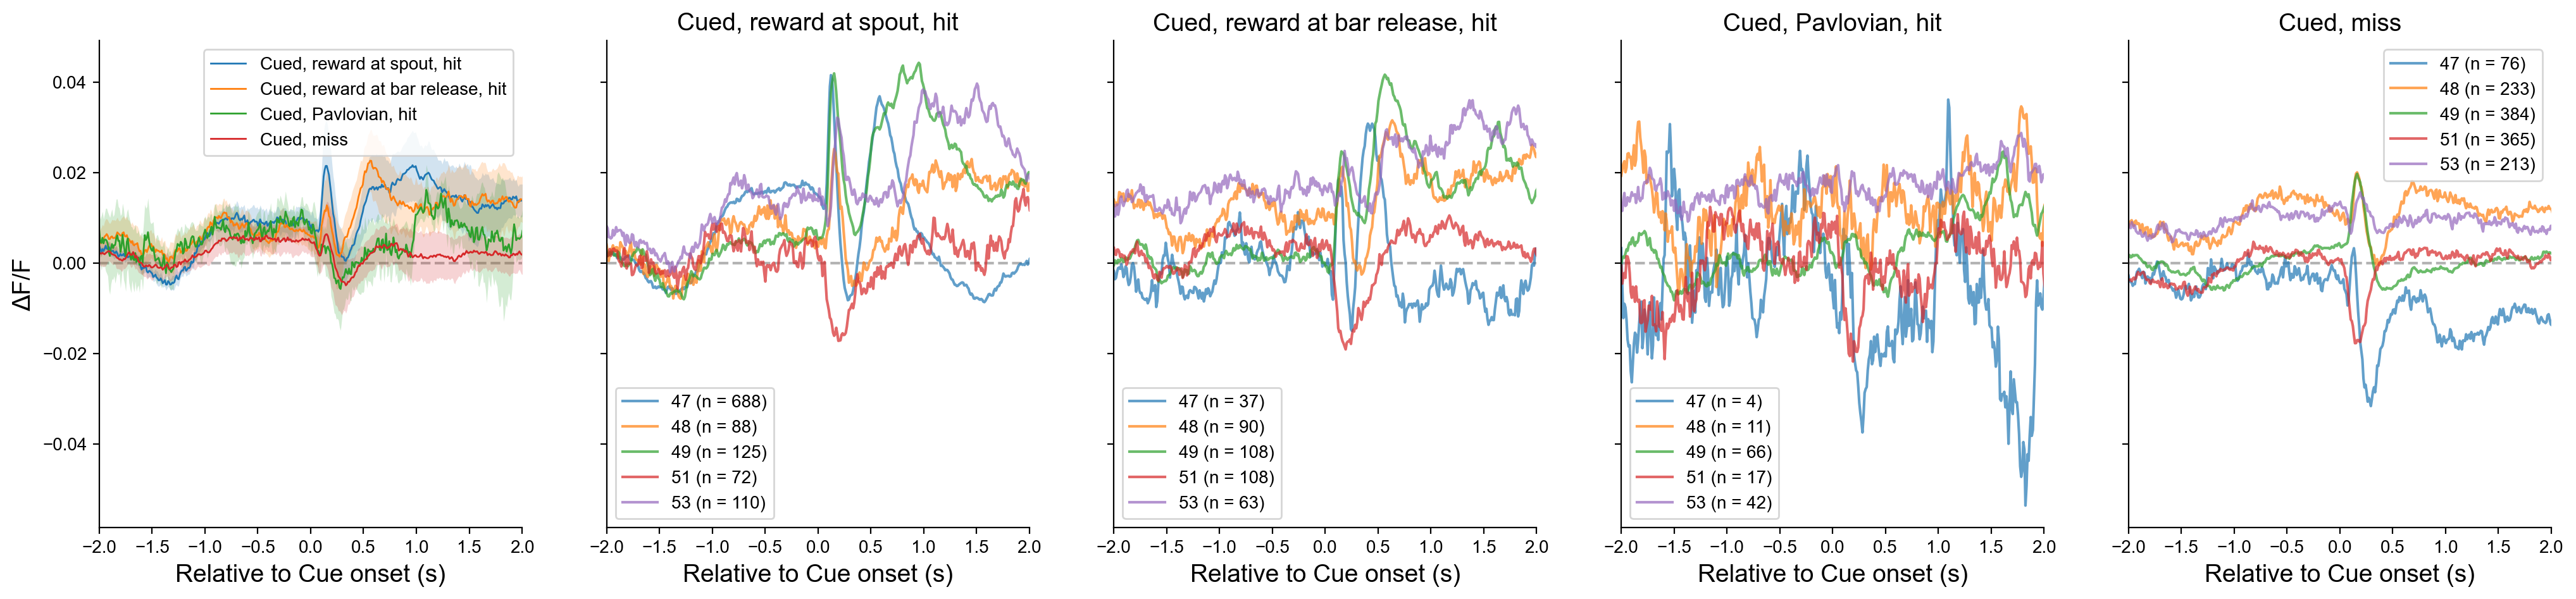

In [92]:
import trialexp.utils.pycontrol_utilities as pycutl

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2) 
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev=None,
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([4,5,6]) # Cued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df1 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to Cue onset (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to Cue onset (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df1

# Cued, spout touch, on 19 Sep onwards

- Still this contains a lot of sessions with bad performance
- How to narrow this down to good performance only?
- **Need to combine this analysis with pyControl analysis**

No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx

condition_ID  condition_trial_n                   condition_alias  \
0              0               1083        Cued, reward at spout, hit   
1              0               1083        Cued, reward at spout, hit   
2              0               1083        Cued, reward at spout, hit   
3              0               1083        Cued, reward at spout, hit   
4              0               1083        Cued, reward at spout, hit   
5              1                406  Cued, reward at bar release, hit   
6              1                406  Cued, reward at bar release, hit   
7              1                406  Cued, reward at bar release, hit   
8              1                406  Cued, reward at bar release, hit   
9              1                406  Cued, reward at bar release, hit   
10             2                140              Cued, Pavlovian, hit   
11             2                140              Cued, Pavlovian, hit   
12             2                140              Cued, Pavlovian, hit   
13             2                140              Cued, Pavlovian, hit   
14             2                140              Cued, Pavlovian, hit   
15             3                575                        Cued, miss   
16             3                575                        Cued, miss   
17             3                575                        Cued, miss   
18             3                575                        Cued, miss   
19             3                575                        Cued, miss   

    group_ID  group_trial_n  subject_ID  subject_trial_n  
0          0           1083          47              688  
1          0           1083          48               88  
2          0           1083          49              125  
3          0           1083          51               72  
4          0           1083          53              110  
5          0            406          47               37  
6          0            406          48               90  
7          0            406          49              108  
8          0            406          51              108  
9          0            406          53               63  
10         0            140          47                4  
11         0            140          48               11  
12         0            140          49               66  
13         0            140          51               17  
14         0            140          53               42  
15         0            575          47               11  
16         0            575          48               92  
17         0            575          49              198  
18         0            575          51              189  
19         0            575          53               85

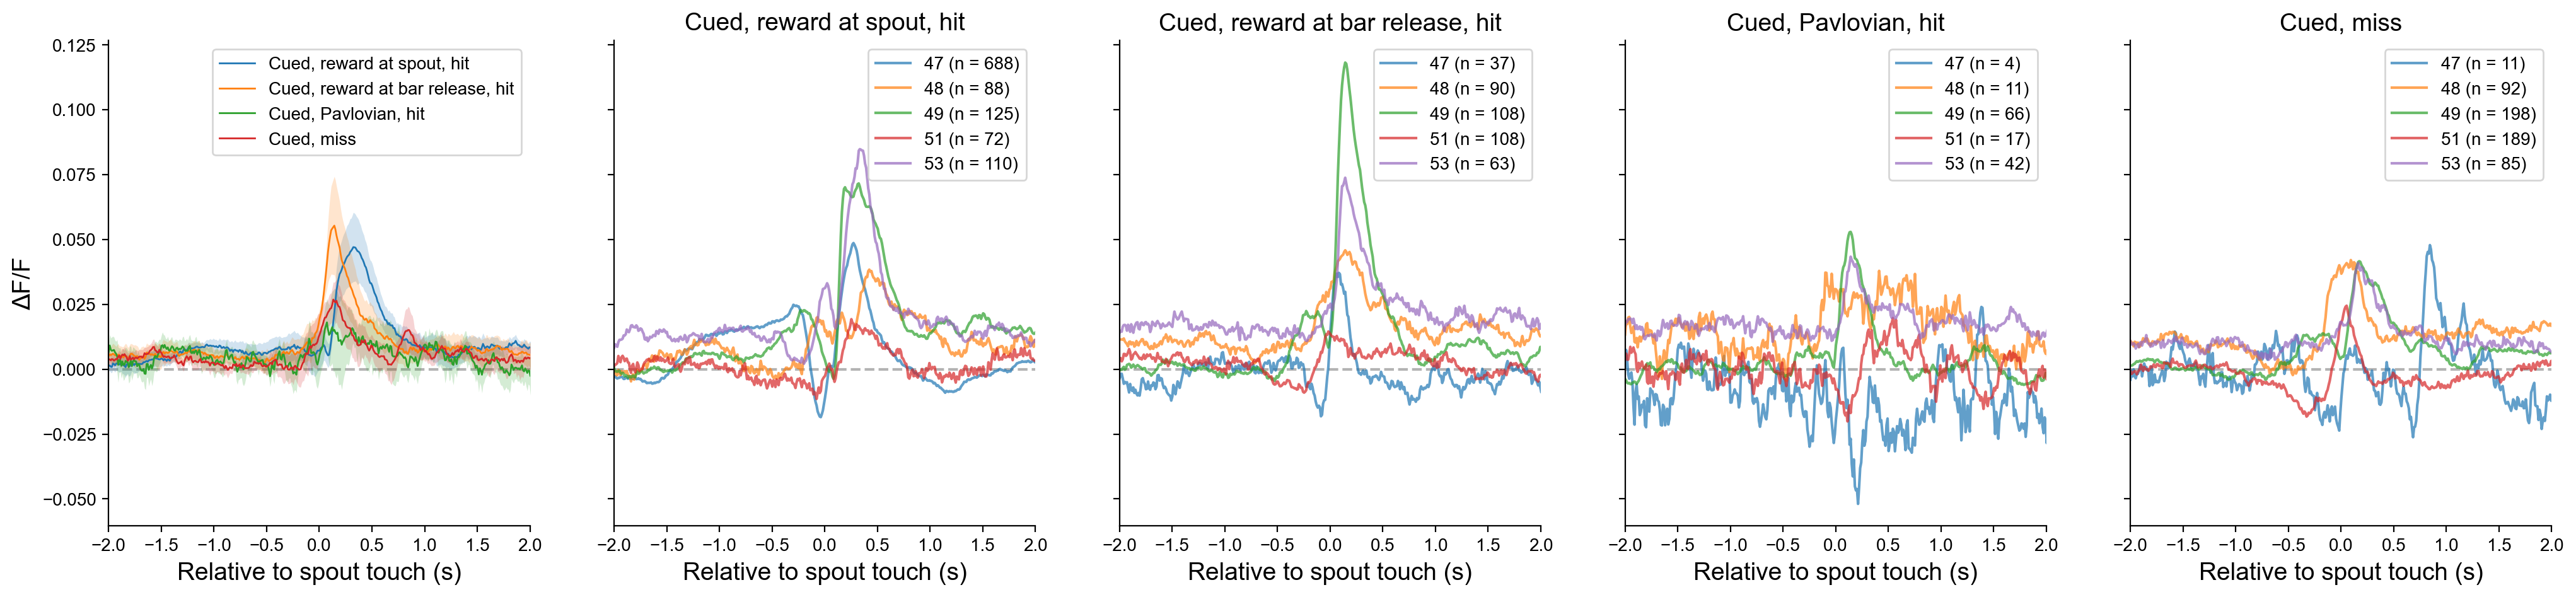

In [93]:

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2)
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev='spout',
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([4, 5, 6])  # Cued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df2 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to spout touch (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to spout touch (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df2


# Uncued, spout touch, on 19 Sep onwards

- Still this contains a lot of sessions with bad performance
- How to narrow this down to good performance only?
- **Need to combine this analysis with pyControl analysis**

No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 4, group_idx 0, subj 47
cond_ID: 4, group_idx 0, subj 48
cond_ID: 4, group_idx 0, subj 49
cond_ID: 4, group_idx 0, subj 51
cond_ID: 4, group_idx 0, subj 53
cond_ID: 5, group_idx 0, subj 47
cond_ID: 5, group_idx 0, subj 48
cond_ID: 5, group_idx 0, subj 49
cond_ID: 5, group_idx

condition_ID  condition_trial_n                     condition_alias  \
0              4                860        Uncued, reward at spout, hit   
1              4                860        Uncued, reward at spout, hit   
2              4                860        Uncued, reward at spout, hit   
3              4                860        Uncued, reward at spout, hit   
4              4                860        Uncued, reward at spout, hit   
5              5                108  Uncued, reward at bar release, hit   
6              5                108  Uncued, reward at bar release, hit   
7              5                108  Uncued, reward at bar release, hit   
8              5                108  Uncued, reward at bar release, hit   
9              5                108  Uncued, reward at bar release, hit   
10             6                303                        Uncued, miss   
11             6                303                        Uncued, miss   
12             6                303                        Uncued, miss   
13             6                303                        Uncued, miss   
14             6                303                        Uncued, miss   

    group_ID  group_trial_n  subject_ID  subject_trial_n  
0          0            860          47              531  
1          0            860          48              125  
2          0            860          49               43  
3          0            860          51              138  
4          0            860          53               23  
5          0            108          47                5  
6          0            108          48               26  
7          0            108          49               41  
8          0            108          51               23  
9          0            108          53               13  
10         0            303          47               44  
11         0            303          48               74  
12         0            303          49               75  
13         0            303          51               74  
14         0            303          53               36

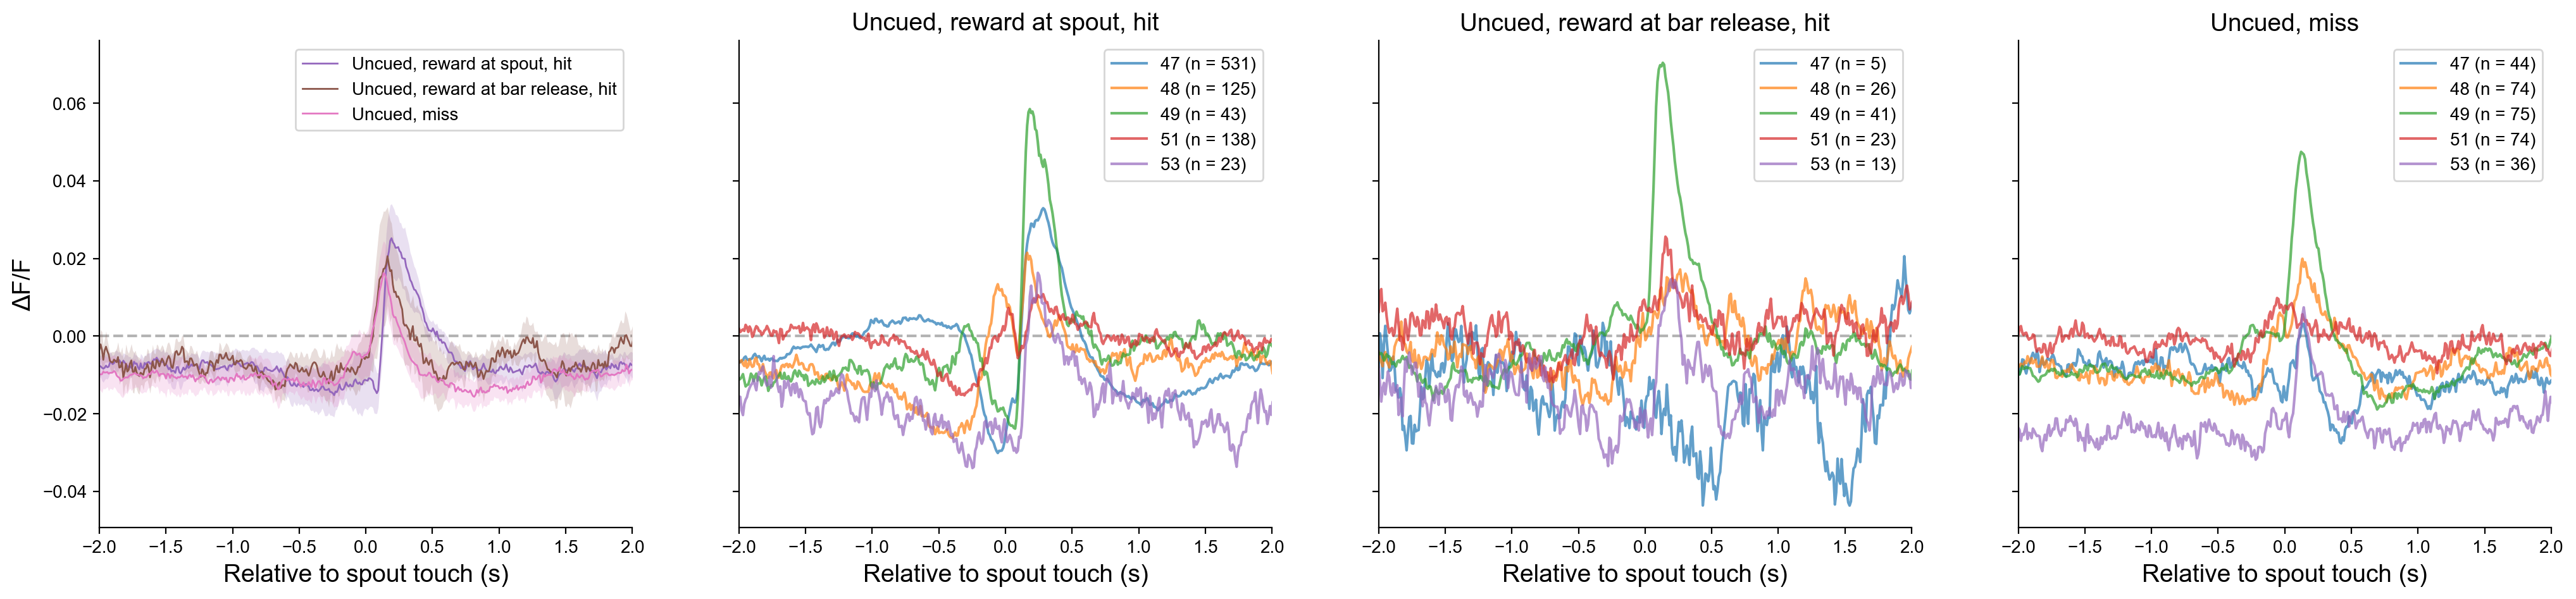

In [94]:


exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2)
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev='spout',
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([0, 1, 2, 3])  # Uncued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df3 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to spout touch (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to spout touch (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df3

# Cued, bar release, on 19 Sep onwards

- Still this contains a lot of sessions with bad performance
- How to narrow this down to good performance only?df
- **Need to combine this analysis with pyControl analysis**

No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx

condition_ID  condition_trial_n                   condition_alias  \
0              0               1071        Cued, reward at spout, hit   
1              0               1071        Cued, reward at spout, hit   
2              0               1071        Cued, reward at spout, hit   
3              0               1071        Cued, reward at spout, hit   
4              0               1071        Cued, reward at spout, hit   
5              1                396  Cued, reward at bar release, hit   
6              1                396  Cued, reward at bar release, hit   
7              1                396  Cued, reward at bar release, hit   
8              1                396  Cued, reward at bar release, hit   
9              1                396  Cued, reward at bar release, hit   
10             2                114              Cued, Pavlovian, hit   
11             2                114              Cued, Pavlovian, hit   
12             2                114              Cued, Pavlovian, hit   
13             2                114              Cued, Pavlovian, hit   
14             2                114              Cued, Pavlovian, hit   
15             3                820                        Cued, miss   
16             3                820                        Cued, miss   
17             3                820                        Cued, miss   
18             3                820                        Cued, miss   
19             3                820                        Cued, miss   

    group_ID  group_trial_n  subject_ID  subject_trial_n  
0          0           1071          47              688  
1          0           1071          48               86  
2          0           1071          49              115  
3          0           1071          51               72  
4          0           1071          53              110  
5          0            396          47               37  
6          0            396          48               89  
7          0            396          49              103  
8          0            396          51              107  
9          0            396          53               60  
10         0            114          47                4  
11         0            114          48               10  
12         0            114          49               52  
13         0            114          51               16  
14         0            114          53               32  
15         0            820          47               68  
16         0            820          48              152  
17         0            820          49              268  
18         0            820          51              222  
19         0            820          53              110

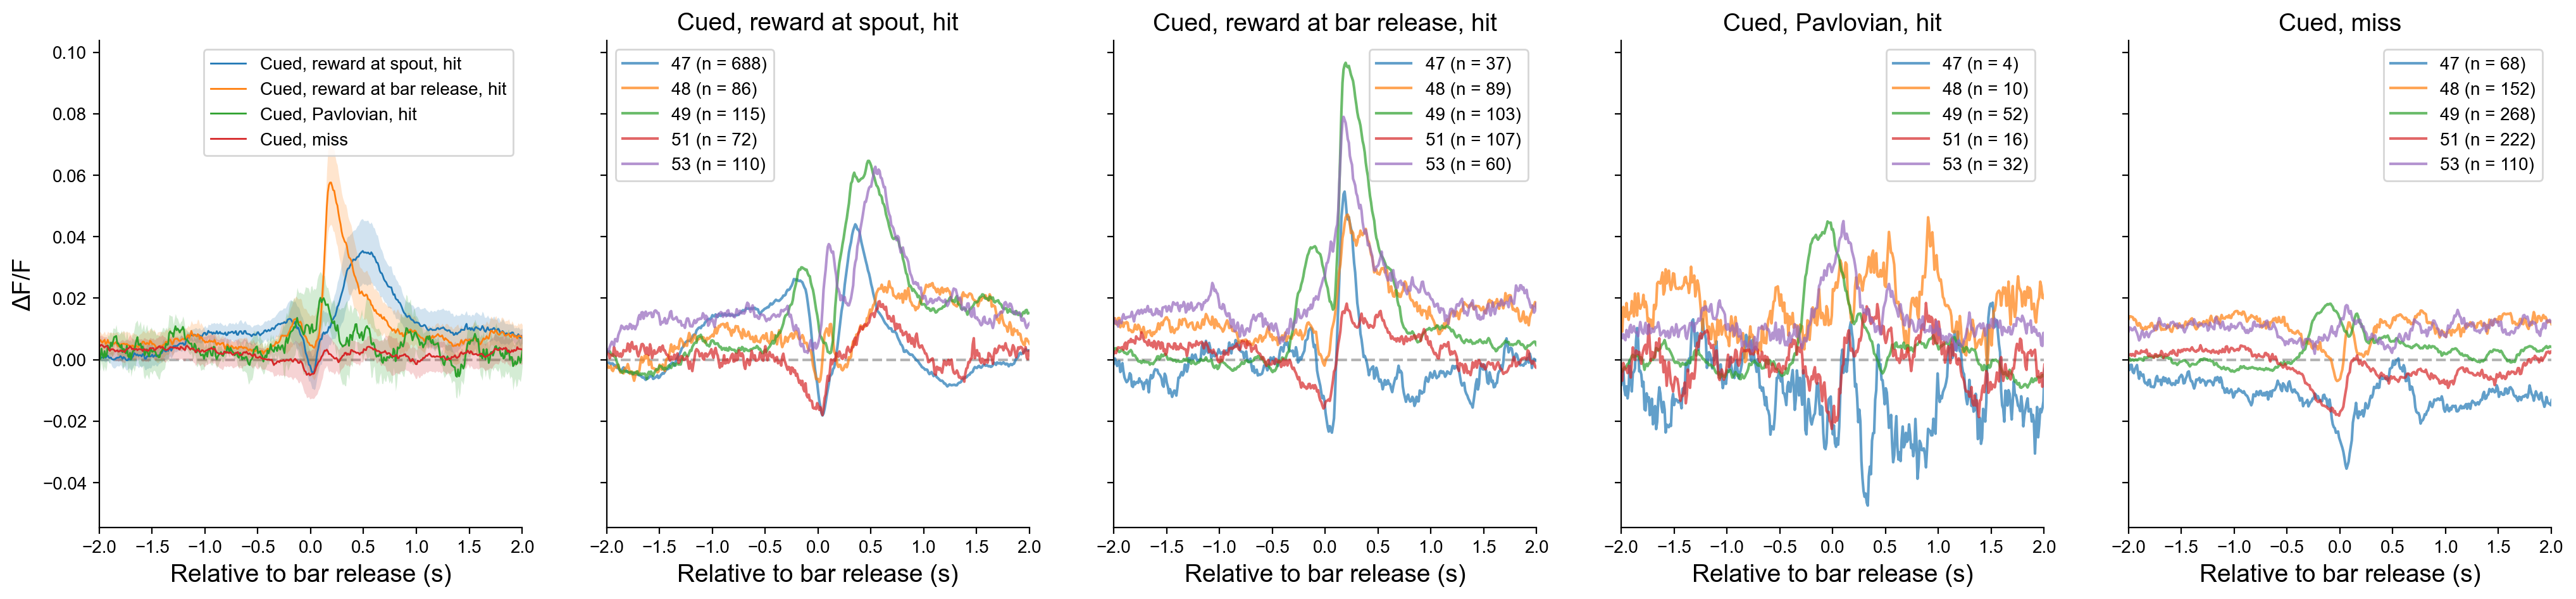

In [95]:

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2)
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev='bar_off',
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([4,5,6])  # Cued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df4 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to bar release (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to bar release (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df4


# Uncued, bar release, on 19 Sep onwards

- Still this contains a lot of sessions with bad performance
- How to narrow this down to good performance only?
- **Need to combine this analysis with pyControl analysis**

No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 4, group_idx 0, subj 47
cond_ID: 4, group_idx 0, subj 48
cond_ID: 4, group_idx 0, subj 49
cond_ID: 4, group_idx 0, subj 51
cond_ID: 4, group_idx 0, subj 53
cond_ID: 5, group_idx 0, subj 47
cond_ID: 5, group_idx 0, subj 48
cond_ID: 5, group_idx 0, subj 49
cond_ID: 5, group_idx

condition_ID  condition_trial_n                     condition_alias  \
0              4                860        Uncued, reward at spout, hit   
1              4                860        Uncued, reward at spout, hit   
2              4                860        Uncued, reward at spout, hit   
3              4                860        Uncued, reward at spout, hit   
4              4                860        Uncued, reward at spout, hit   
5              5                107  Uncued, reward at bar release, hit   
6              5                107  Uncued, reward at bar release, hit   
7              5                107  Uncued, reward at bar release, hit   
8              5                107  Uncued, reward at bar release, hit   
9              5                107  Uncued, reward at bar release, hit   
10             6                311                        Uncued, miss   
11             6                311                        Uncued, miss   
12             6                311                        Uncued, miss   
13             6                311                        Uncued, miss   
14             6                311                        Uncued, miss   

    group_ID  group_trial_n  subject_ID  subject_trial_n  
0          0            860          47              531  
1          0            860          48              125  
2          0            860          49               43  
3          0            860          51              138  
4          0            860          53               23  
5          0            107          47                5  
6          0            107          48               25  
7          0            107          49               41  
8          0            107          51               23  
9          0            107          53               13  
10         0            311          47               46  
11         0            311          48               75  
12         0            311          49               77  
13         0            311          51               75  
14         0            311          53               38

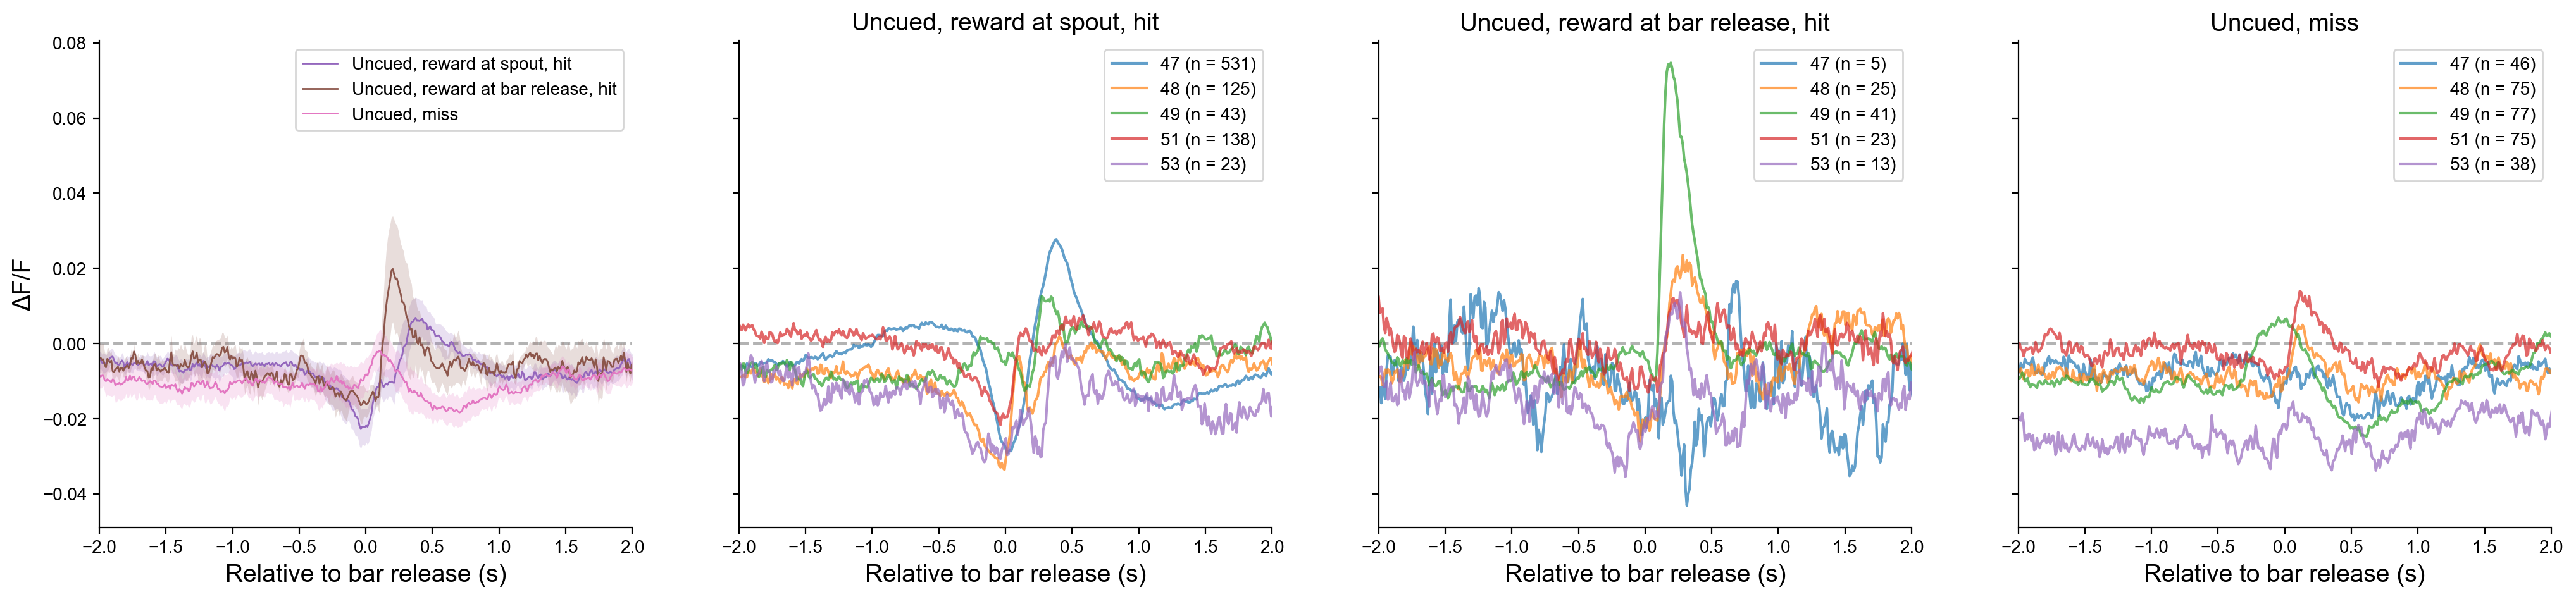

In [96]:

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2)
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev='bar_off',
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([0, 1, 2, 3])  # Uncued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1),
                      datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df5 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to bar release (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to bar release (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df5


# Summary of Meeting on 4 Oct 2022

## Success rate changes
  - Not popular

## Cued/Uncued
- They are very similar except a few things
  - we don't have the presumably cue-related first peak (T < 0 when relative to bar release) in Uncued
  - Because it is far away in time, we don't see bar-hold related dopamine much (how do they bar-hold activity look in Uncued?)
- Apart from cue-related responses, dopamine dynamics are very similar between Cued/Uncued
  - Yet, **the validity negative-to-positive dopamine change is now confirmed in Uncued condition.**
- We can say that we don't know about how any other neurons, MSNs or ChAT, behave during behaviour or learning.
- So it's worth a try, but right now, we don't have a strong reason to believe that they fire very differently right now.
  - Again, we don't have a hypothesis.
- How about subtracting the average curves?

### miss
- **miss** is ill defined in this task. And it is very confusing.
- Cued, miss
  - They can touch the spout after CS_Go (= during the interval) and even collect a delayed reward.
- Uncued, miss
  - They receive a reward at the end of 20-30s CS_Go period.
  - **Relative to spout touches**: Because there should not be any spout touch during CS_Go (20-30s) in miss, you should not be able to plot any trials. But there are many. 
    - If they have missed during CS_Go, but had a spout touch before, those can be plotted here?  _There must be some kind of a bug_.
    - They 
  - **Relative to bar release**: In Miss trials, bar release can be a very small movement or nearly touching the spout but just missed. The latter case would be accompanied by a clear dip of dopamine signal. This can be explored with Deep Lab Cut. This category can be highly heterogeneous.
  - Unrelated, but what about spout touches (hit) during CS_Go, but way after 4s or 6s trial_window? Those successful touches are discarded??


## Changes
- Julien wants to introduce longer ITI for Cued/Uncued
- Julien wants to introduce 10% error trials (omit reward); we'll see negative RPE responses of dopamine neurons


## Cued, bar touch

No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx

False    3880
True     2900
Name: keep, dtype: int64

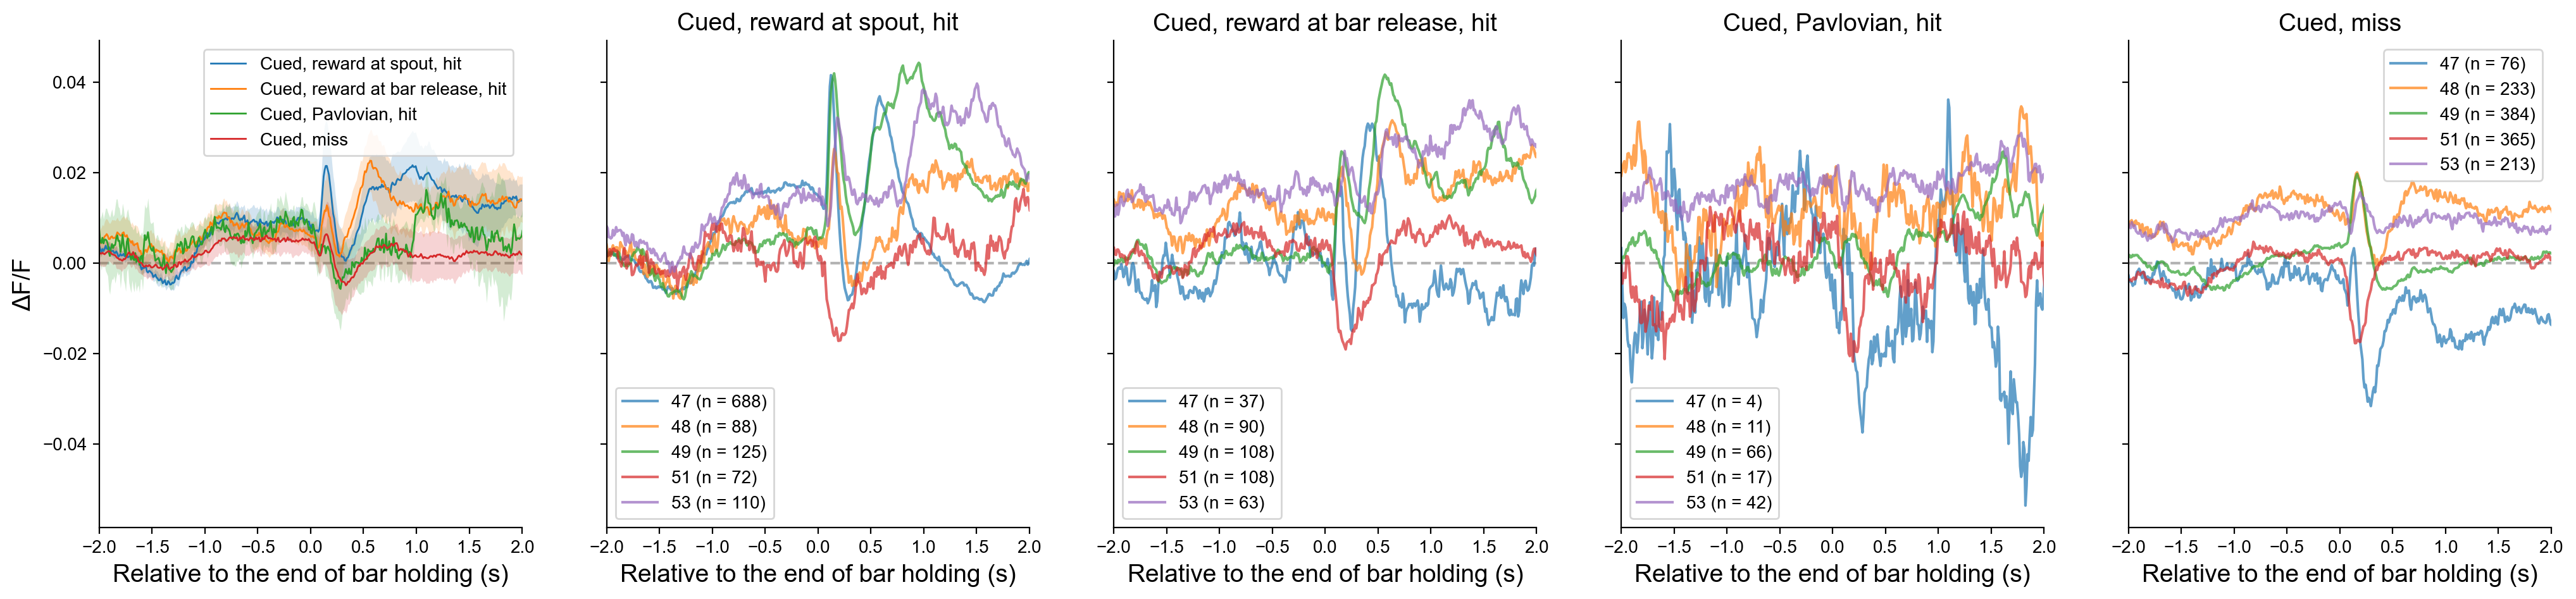

In [99]:

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2)
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev=None, # CS_Go = end of hold_start
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([4, 5, 6])  # Uncued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1),
                      datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df5 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to the end of bar holding (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to the end of bar holding (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()


## Uncude, hold start

data_import.py

line 1175 error

get_photometry_groups 1937
get_photometry_trials 908
get_trials_times_from_conditions 1175


self.evettoprocess = ['bar', 'bar_off', 'spout']

```python
elif trig_on_ev not in self.events_to_process:
            raise Exception('trig_on_ev not in events_to_process')
```

No trial in any condition for subject 47 at: 2022-08-25 15:02:53
No trial in any condition for subject 48 at: 2022-08-26 12:13:43
No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 51 at: 2022-08-24 11:41:39
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22
No trial in any condition for subject 53 at: 2022-09-27 14:24:36
No trial in any condition for subject 53 at: 2022-09-27 14:29:22
cond_ID: 4, group_idx 0, subj 47
cond_ID: 4, group_idx 0, subj 48
cond_ID: 4, group_idx 0, subj 49
cond_ID: 4, group_idx 0, subj 51
cond_ID: 4, group_idx 0, subj 53
cond_ID: 5, group_idx 0, subj 47
cond_ID: 5, group_idx 0, subj 48
cond_ID: 5, group_idx 0, subj 49
cond_ID: 5, group_idx

False    5446
True     1334
Name: keep, dtype: int64

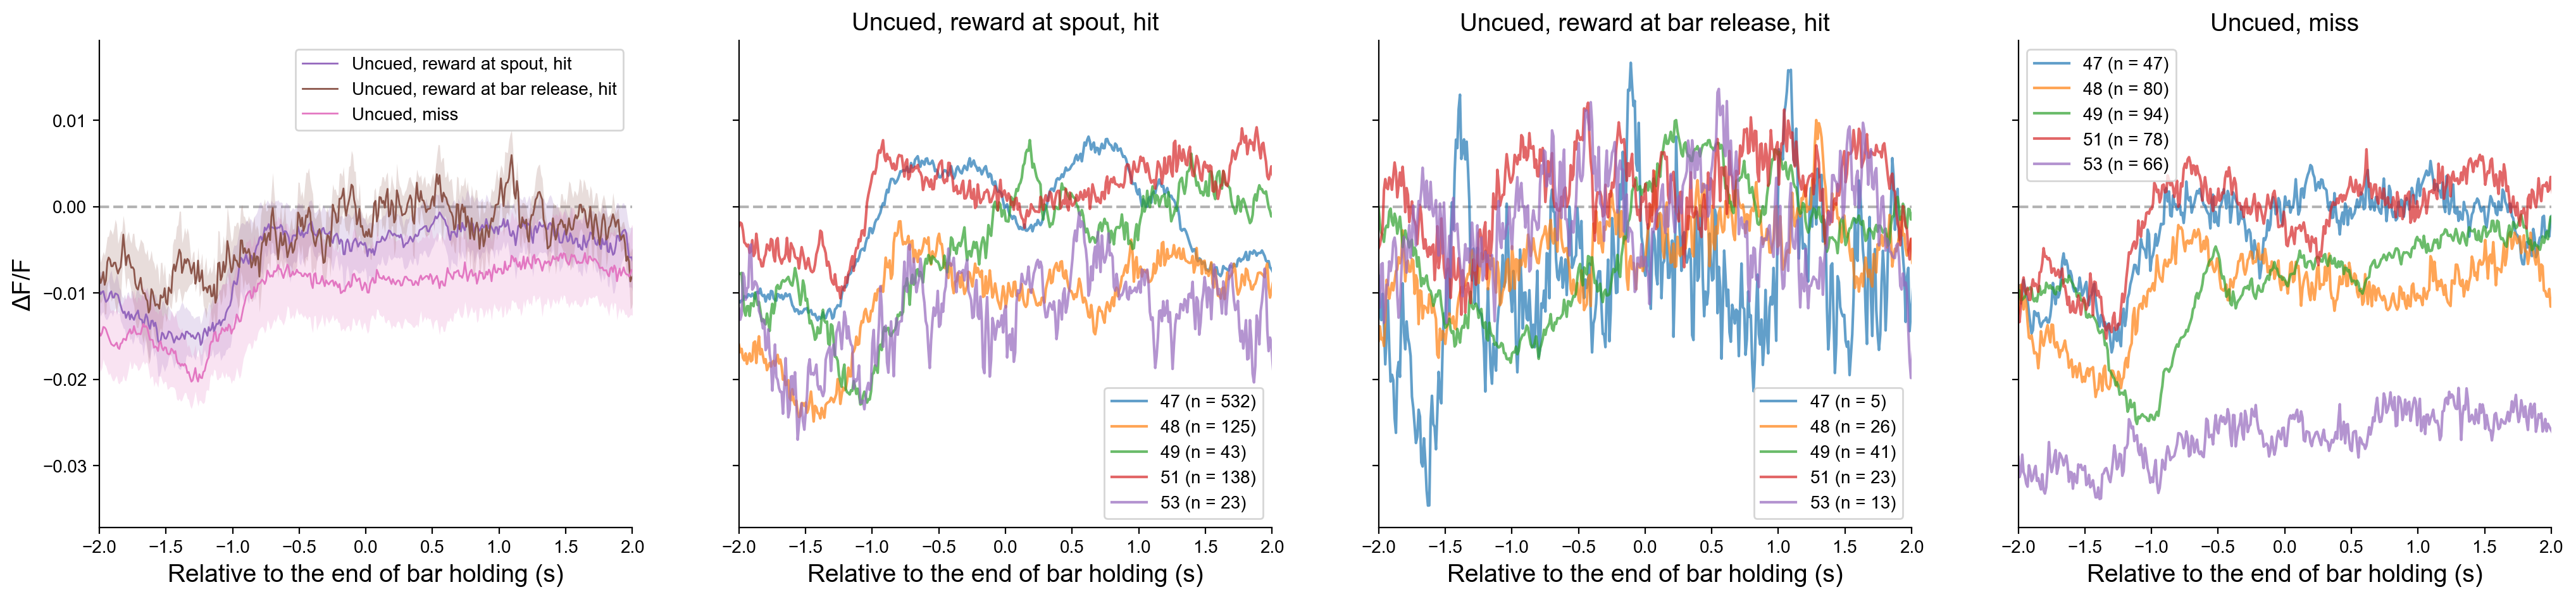

In [100]:


exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if (session.subject_ID in [47, 48, 49, 51, 53]) and (session.number > 2)
                       and (session.task_name == 'reaching_go_spout_cued_uncued')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='reaching_go_spout_cued_uncued',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev=None,
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.set_trial_window(trial_window, 'ms')

cont_dataset.filterout_conditions([0, 1, 2, 3])  # Uncued only
dlist = pd.date_range(datetime.datetime(2022, 4, 1),
                      datetime.datetime(2022, 9, 18)).tolist()
cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([-2, 6], 's')


fig, axs, df5 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=pycutl.cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to the end of bar holding (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to the end of bar holding (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()
